In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import matplotlib.pyplot as plt
tqdm.pandas()

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
PATH = '/content/drive/MyDrive/dataset/melon/'

In [ ]:
song_meta = pd.read_json(PATH+'song_meta.json')
genre = pd.read_json(PATH+'genre_all.json')
train = pd.read_json(PATH+'train.json')

In [ ]:
train.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000


In [ ]:
song_meta.head(3)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2


# 노래별 장르

## 1. 플레이리스트 대장르 체크

In [ ]:
def get_genres(df):
    ret = []
    genres = []
    songs = df['songs'].values
    
    for song in songs:
        ret += song
        
    ret = list(set(ret))
    
    for song in tqdm(ret):
        genres += song_meta.loc[song]['song_gn_gnr_basket']
        
    return genres

In [ ]:
songs_in_train = get_genres(train)

  0%|          | 0/615142 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(columns=['genre_code'])
df['genre_code'] = songs_in_train
df = pd.merge(df, genre, how='left', on='genre_code')
df.head()

,genre_code,genre
0,GN0900,POP
1,GN1100,일렉트로니카
2,GN1800,뉴에이지
3,GN1700,재즈
4,GN1600,클래식


<Figure size 432x288 with 0 Axes>

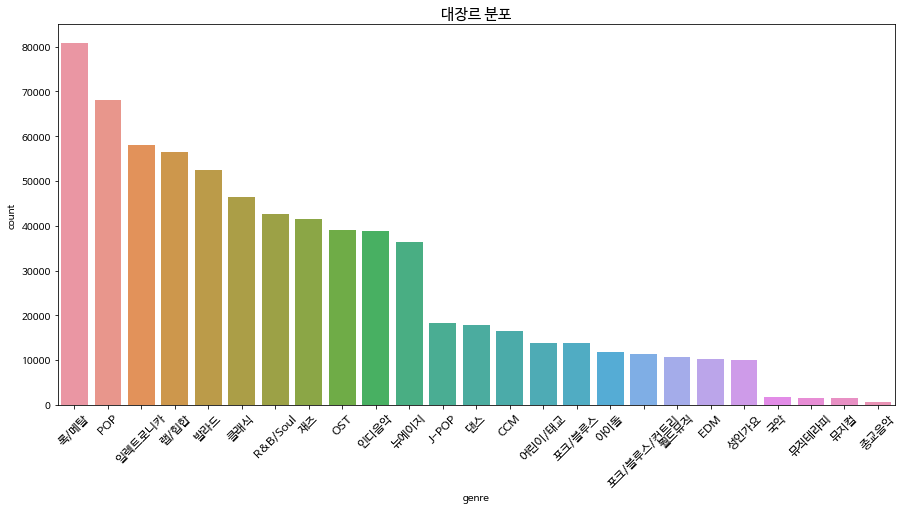

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.countplot(data=df, x='genre', order=df['genre'].value_counts().index)
ax.set_title('대장르 분포', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.figure()

가장 많은 대장르는 '록/메탈'인 것을 알 수 있습니다.  
그 다음으로는 POP이 나타나고 있습니다. 

## 2. 세부 장르 + 대장르 분포로 확인

In [ ]:
def song_genre_list(x):
    songs = x['songs']
    tmp = []
    
    for song in songs:
        ls = song_meta.loc[song]['song_gn_dtl_gnr_basket']
        res = list(map(lambda st: st[:-1]+'0' if st[-1] == '1' else st, ls))
        tmp += res
    
    return dict(Counter(tmp))

In [ ]:
train['genre_list'] = train.progress_apply(song_genre_list, axis=1)

  0%|          | 0/115071 [00:00<?, ?it/s]

In [ ]:
train['max_genre'] = train['genre_list'].progress_apply(lambda x: [k for k, v in x.items() if max(x.values()) == v])

  0%|          | 0/115071 [00:00<?, ?it/s]

In [ ]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,genre_list,max_genre
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"{'GN1402': 3, 'GN1400': 3, 'GN0900': 10, 'GN09...","[GN0900, GN1000]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"{'GN0100': 11, 'GN0103': 1, 'GN0600': 8, 'GN06...",[GN0100]
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"{'GN0400': 15, 'GN0403': 10, 'GN0500': 12, 'GN...",[GN0400]
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"{'GN0908': 1, 'GN1509': 3, 'GN0900': 5, 'GN220...",[GN0100]
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"{'GN0100': 5, 'GN0103': 3, 'GN2502': 8, 'GN250...",[GN0200]


플레이리스트에 있는 노래들의 장르를 `Counter`를 통해 빈도를 계산했습니다.  
이를 활용해서 최빈값으로 등장하는 genre들을 `max_genre`로 설정했습니다.

In [ ]:
gnr = genre.copy()
gnr = gnr.set_index('genre_code')

train['max_genre_nm'] = train['max_genre'].progress_apply(lambda x : list(gnr.loc[x]['genre'].values))

  0%|          | 0/115071 [00:00<?, ?it/s]

In [ ]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,genre_list,max_genre,max_genre_nm
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"{'GN1402': 3, 'GN1400': 3, 'GN0900': 10, 'GN09...","[GN0900, GN1000]","[POP, 록/메탈]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"{'GN0100': 11, 'GN0103': 1, 'GN0600': 8, 'GN06...",[GN0100],[발라드]
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"{'GN0400': 15, 'GN0403': 10, 'GN0500': 12, 'GN...",[GN0400],[R&B/Soul]
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"{'GN0908': 1, 'GN1509': 3, 'GN0900': 5, 'GN220...",[GN0100],[발라드]
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"{'GN0100': 5, 'GN0103': 3, 'GN2502': 8, 'GN250...",[GN0200],[댄스]


`max_genre`에 맞는 장르들의 이름을 리스트로 가져온 결과입니다.  
우선 태그와 장르가 직접적인 연관성이 있는지 확인하기 위해 태그들을 수치로 변환하겠습니다.  
해당 태그에서 많이 나타난 장르를 태그의 숫자로 매핑하겠습니다.

In [ ]:
ret = []

for tag in tqdm(train['tags']):
  ret += tag

ret = list(set(ret))

tags = []

for item in ret:
  if item == '': tags.append('')
  else: tags.append(item)

  0%|          | 0/115071 [00:00<?, ?it/s]

In [ ]:
df = train[['tags','max_genre' , 'max_genre_nm']]
genre['label'] = genre['genre_code'].apply(lambda x: int(x.replace('GN', '')))
gnr = genre.copy()
gnr = gnr.set_index('genre_code')

In [ ]:
def tag_dictionary(df):
  dic = {}
  gnr = genre.copy()
  gnr = gnr.set_index('genre_code')

  for i in tqdm(range(len(df))):
    tags = df.loc[i]['tags']
    gnrs = df.loc[i]['max_genre']
    gnr_labels = list(gnr.loc[gnrs]['label'].values)

    for tag in tags:
      if tag not in dic:
        dic[tag] = gnr_labels
      else:
        dic[tag] += gnr_labels

  tmp = {}

  for k, v in dic.items():
    tmp[k] = dict(Counter(v))

  temp = {}

  for k, v in tmp.items():
    temp[k] = round(np.mean([k1 for k1, v1 in v.items() if max(v.values()) == v1]), 2)

  return temp

In [ ]:
tag_dic = tag_dictionary(df)

  0%|          | 0/115071 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
tag_df = pd.DataFrame()
tag_df['tag'] = tag_dic.keys()
tag_df['label'] = tag_dic.values()
tag_df = tag_df.fillna(0)
tag_df = tag_df.set_index('tag', drop=False)

각 태그를 가장 많이 나온 장르 라벨의 평균치로 저장했습니다.  
사실 평균치에 해당하는 장르는 없지만 수치적 비교를 위해 사용합니다.

In [ ]:
def tag_point(x):
  list(tag_df.loc[x]['label'].values)

In [ ]:
df['tag_point'] = df['tags'].progress_apply(lambda x: np.mean(tag_df.loc[x]['label'].values))
df['genre_point'] = df['max_genre'].progress_apply(lambda x: np.mean(gnr.loc[x]['label'].values))

  0%|          | 0/115071 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


  0%|          | 0/115071 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


락 : 900 1000 --> (1000+900) / 2 = 950

In [ ]:
df

,tags,max_genre,max_genre_nm,tag_point,genre_point
0,[락],"[GN0900, GN1000]","[POP, 록/메탈]",1000.000000,950.0
1,"[추억, 회상]",[GN0100],[발라드],100.000000,100.0
2,"[까페, 잔잔한]",[GN0400],[R&B/Soul],100.000000,400.0
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",[GN0100],[발라드],100.000000,100.0
4,[댄스],[GN0200],[댄스],200.000000,200.0
...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",[GN1000],[록/메탈],928.571429,1000.0
115067,[일렉],"[GN1104, GN1100]","[클럽뮤직, 일렉트로니카]",900.000000,1102.0
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",[GN0100],[발라드],237.500000,100.0
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",[GN1000],[록/메탈],375.000000,1000.0


`tag_point`는 해당 플레이리스트를 위에서 적용한 태그의 라벨들의 수치 평균을 적용했습니다.  
`genre_point`는 해당 플레이리스트의 `max_genre`에 나타난 장르값을 평균치 낸 결과입니다.  
두 수치의 상관관계 분석을 진행하겠습니다.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


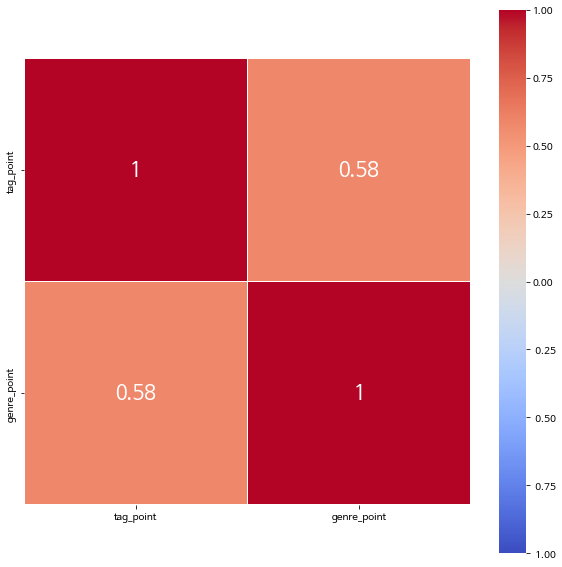

In [ ]:
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, annot_kws={"size": 20}, square=True, linewidth=.1,
            cmap='coolwarm', vmax=1.0, vmin=-1.0)
plt.show()

대략적인 장르와 태그의 상관관계는 0.58정도가 나오는 것으로 확인됩니다.  
이 부분에 대해서 **통계적 검정**을 사용하면 좋을 것으로 보입니다.

## 2. 태그 분포 확인

In [ ]:
def get_tags(df):
  ret = []
  tags = df['tags'].values

  for tag in tags:
    ret += tag

  return ret

In [ ]:
tags = get_tags(train)
tag_freq = Counter(tags)
tag_df = pd.DataFrame()
tag_df['tags'] = dict(tag_freq).keys()
tag_df['count'] = dict(tag_freq).values()
tag_df = tag_df.sort_values(['count'], ignore_index=True, ascending=False)

In [ ]:
from wordcloud import WordCloud

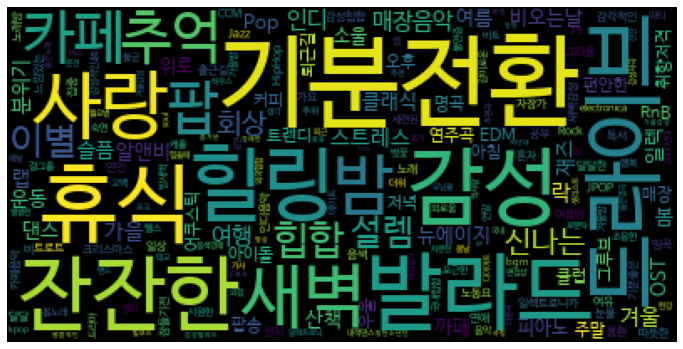

In [ ]:
font = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
img_path = '/content/drive/MyDrive/dataset/melon/images/'

wc = WordCloud(font_path=font, max_font_size=60)
cloud = wc.generate_from_frequencies(tag_freq)

plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

In [ ]:
# 'artist_name_basket'
def get_artist_list(df):
  ret = []

  artists = df['artist_name_basket'].values

  for artist in artists:
    ret += artist
  
  ret = list(set(ret))

  return ret

In [ ]:
artists = get_artist_list(song_meta)

if '드렁큰타이거' in artists:
  print(1)

In [ ]:
for artist in artists:
  if '드렁큰' in artist:
    print(artist)

드렁큰 타이거
드렁큰레드긱스
